In [1]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

# Miguel Angel Ruiz Ortiz
## Procesamiento de Lenguaje Natural
## Proyecto final - MiniLM: Deep Self-Attention Distillation for Task-Agnostic Compression of Pre-Trained Transformers

In [2]:
from google.colab import drive
drive.mount("/content/drive")

import os
os.environ['HF_DATASETS_CACHE'] = "/content/drive/My Drive/Academic Stuff/NLP (CIMAT)/project-aux-files/datasets"

Mounted at /content/drive


In [3]:
from typing import Optional
from pathlib import Path
import json
import time
from datetime import datetime

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, IterableDataset
import torch.nn as nn
import torch.optim as optim

from transformers import BertConfig, BertModel, BertTokenizerFast, get_linear_schedule_with_warmup, DataCollatorForLanguageModeling, DataCollatorWithPadding
from datasets import load_dataset, load_from_disk

from tqdm.notebook import tqdm

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [4]:
base_path = Path("/content/drive/My Drive/Academic Stuff/NLP (CIMAT)")

# carpetas
aux_files_dir = base_path / "project-aux-files" # utils
savedir = aux_files_dir / "saved-models" # carpeta para guardar mejor modelo entrenado
savedir_students = aux_files_dir / "saved-models-students" # carpeta para guardar mejores modelos entrenados para SST-2
tensorboard_dir = aux_files_dir / "logs" # carpeta para guardar logs de tensorboard

# Tokenizador de Bert (Base)

In [5]:
# Load tokenizer and data
TEACHER_NAME = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(TEACHER_NAME)
teacher_config = BertConfig.from_pretrained(TEACHER_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
MAX_SEQ_LEN = 512

def tokenize_function(samples):
    return tokenizer(
        samples['text'],
        truncation=True,
        max_length=MAX_SEQ_LEN,
        return_special_tokens_mask=True
    )

# Dataset BookCorpus

In [17]:
raw_dataset = load_dataset("bookcorpus", split="train", trust_remote_code=True)

README.md:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

bookcorpus.py:   0%|          | 0.00/3.25k [00:00<?, ?B/s]

In [ ]:
dataset = raw_dataset.train_test_split(test_size=0.01, seed=13)
train_ds = dataset['train']
train_ds_len = len(train_ds)

README.md:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

bookcorpus.py:   0%|          | 0.00/3.25k [00:00<?, ?B/s]

Dataset como stream para tokenizar "on the fly"

In [ ]:
train_ds = train_ds.to_iterable_dataset(num_shards=64)
train_stream = (
    train_ds
    .shuffle(buffer_size=5000)
    .map(
        tokenize_function,
        batched=True,
        batch_size=1000,
        remove_columns=["text"],
    )
    .with_format("torch")
)

Función que realiza el preprocesamiento para *Masked Language Modelling*

In [7]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [ ]:
BATCH_SIZE = 64

train_loader = DataLoader(
    train_stream,
    batch_size=BATCH_SIZE,
    num_workers=2,
    collate_fn=data_collator,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

# Definición de modelos *Teacher*, *Student*

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Teacher Model
teacher = BertModel.from_pretrained(TEACHER_NAME, add_pooling_layer=False, output_attentions=True, output_hidden_states=True).to(DEVICE)
teacher.eval()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [8]:
# Student model
STUDENT_LAYERS = 3
STUDENT_HIDDEN = 384
DROPOUT = 0.1

student_config = BertConfig(
    vocab_size=teacher_config.vocab_size,
    hidden_size=STUDENT_HIDDEN,
    num_hidden_layers=STUDENT_LAYERS,
    num_attention_heads=teacher_config.num_attention_heads,
    intermediate_size=STUDENT_HIDDEN * 4,
    hidden_dropout_prob=DROPOUT,
    attention_probs_dropout_prob=DROPOUT,
    max_position_embeddings=teacher_config.max_position_embeddings,
    type_vocab_size=teacher_config.type_vocab_size,
    output_attentions=True,
    output_hidden_states=True
)

In [11]:
student = BertModel(student_config, add_pooling_layer=False).to(DEVICE)

# Funciones de costo

In [12]:
# Distillation Loss Functions
def attention_distribution_loss(a_s, a_t):
    # a_s, a_t: (batch, heads, seq, seq)
    a_s = a_s.clamp(min=1e-9) # avoid log(0)
    return F.kl_div(
        a_s.log(), # corregir
        a_t,
        reduction='batchmean'
    )

def value_relation_loss(v_s, v_t):
    # v_s, v_t: (batch, heads, seq, dim)
    # compute relations
    r_s = torch.matmul(v_s, v_s.transpose(-1, -2)) / (v_s.size(-1) ** 0.5)
    r_t = torch.matmul(v_t, v_t.transpose(-1, -2)) / (v_t.size(-1) ** 0.5)
    return F.kl_div(
        F.log_softmax(r_s, dim=-1),
        F.softmax(r_t, dim=-1),
        reduction='batchmean'
    )

# Destilación

In [ ]:
# Optimizer and Scheduler
PEAK_LR = 3e-4
TOTAL_STEPS = 50_000
WEIGHT_DECAY = 0.01

optimizer = optim.AdamW(
    student.parameters(),
    lr=PEAK_LR,
    weight_decay=WEIGHT_DECAY,
    )
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1*TOTAL_STEPS),
    num_training_steps=TOTAL_STEPS
)

In [23]:
def save_checkpoint(
    state: dict, checkpoint_path: Path, files_suffix: str
):
    torch.save(state, checkpoint_path / f"chkpnt_{files_suffix}.pt")

def save_loss(loss_list: list[float], steps_list: list[int], loss_path: Path):
    with open(loss_path, "a") as f:
        for step, l in zip(steps_list, loss_list):
            f.write(f"{step},{l}\n")

In [ ]:
# Training loop
step = 0
NUM_EPOCHS = 1
start = time.time()

best_metric = 0

loss_file = aux_files_dir / "losses.csv"
loss_list = []
steps_list = []
STEPS_FOR_FLUSH = 100
STEPS_FOR_CHKPT = 500
STEPS_FOR_BOARD = 50

start_time = time.time()

writer = SummaryWriter(tensorboard_dir)

for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]")

    for batch in tqdm(train_loader, desc="Epoch", total=train_ds_len):

        student.train()

        if step >= TOTAL_STEPS:
            break

        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)

        with torch.no_grad():
            out_t = teacher(input_ids, attention_mask=attention_mask)
            attn_t = out_t.attentions[-1]  # last layer
            v_t = teacher.encoder.layer[-1].attention.self.value(out_t.hidden_states[-2])

        out_s = student(input_ids, attention_mask=attention_mask)
        attn_s = out_s.attentions[-1]
        v_s = student.encoder.layer[-1].attention.self.value(out_s.hidden_states[-2])

        # reshape to (batch, heads, seq, dim_head)
        bs, seq, dim = v_s.size()
        v_s = v_s.view(bs, seq, student.config.num_attention_heads, -1).permute(0,2,1,3)
        v_t = v_t.view(bs, seq, teacher.config.num_attention_heads, -1).permute(0,2,1,3)

        loss_attn = attention_distribution_loss(attn_s, attn_t)
        loss_val = value_relation_loss(v_s, v_t)
        loss = loss_attn + loss_val

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        step += 1

        loss_list.append(loss.item())
        steps_list.append(step)

        if step % STEPS_FOR_FLUSH == 0:
            save_loss(loss_list, steps_list, loss_file)
            loss_list = []
            steps_list = []

        if step % STEPS_FOR_BOARD == 0:
            writer.add_scalars('Loss', {"Training": loss.item()}, step)

        if step % STEPS_FOR_CHKPT == 0:
            print(f"Step {step}/{TOTAL_STEPS}, loss: {loss.item():.4f}")
            # Save best model if metric improved
            save_checkpoint(
                {
                    "epoch": epoch + 1,
                    "state_dict": student.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict()
                },
                savedir,
                files_suffix=f"step_{step}"
            )

    if step >= TOTAL_STEPS:
        break

student.save_pretrained(savedir / "final_student")
print("Total time:", time.time() - start)

Epoch [1/1]


Epoch:   0%|          | 0/73264185 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Step 500/50000, loss: 1.8301
Step 1000/50000, loss: 1.3111
Step 1500/50000, loss: 1.1266
Step 2000/50000, loss: 1.2794
Step 2500/50000, loss: 1.1088
Step 3000/50000, loss: 1.2430
Step 3500/50000, loss: 1.0689
Step 4000/50000, loss: 1.0279
Step 4500/50000, loss: 1.0426
Step 5000/50000, loss: 1.0593
Step 5500/50000, loss: 0.8957
Step 6000/50000, loss: 0.9898
Step 6500/50000, loss: 0.9730
Step 7000/50000, loss: 1.0633
Step 7500/50000, loss: 0.8419
Step 8000/50000, loss: 0.9396
Step 8500/50000, loss: 0.9685
Step 9000/50000, loss: 1.0542
Step 9500/50000, loss: 1.0238
Step 10000/50000, loss: 0.9023
Step 10500/50000, loss: 0.8555
Step 11000/50000, loss: 0.9422
Step 11500/50000, loss: 0.9180
Step 12000/50000, loss: 1.0384
Step 12500/50000, loss: 0.9202
Step 13000/50000, loss: 0.8306
Step 13500/50000, loss: 0.8909
Step 14000/50000, loss: 0.8443
Step 14500/50000, loss: 0.7910
Step 15000/50000, loss: 0.9872
Step 15500/50000, loss: 0.7485
Step 16000/50000, loss: 0.8056
Step 16500/50000, loss: 0.77

## 2da destilación

In [27]:
last_state = torch.load(savedir / "chkpnt_step_50000.pt")
student.load_state_dict(last_state["state_dict"])

PEAK_LR = 3e-4
TOTAL_STEPS = 250_000
step = 50_000
WEIGHT_DECAY = 0.01

optimizer = optim.AdamW(
    student.parameters(),
    lr=PEAK_LR,
    weight_decay=WEIGHT_DECAY,
    )
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1*(TOTAL_STEPS-step)),
    num_training_steps=TOTAL_STEPS-step
)

optimizer.load_state_dict(last_state["optimizer"])
scheduler.load_state_dict(last_state["scheduler"])

In [18]:
dataset = raw_dataset.train_test_split(test_size=0.01, seed=53)

In [19]:
train_ds = dataset["train"].to_iterable_dataset(num_shards=64)
train_stream = (
    train_ds
    .shuffle(buffer_size=5000, seed=53)
    .map(
        tokenize_function,
        batched=True,
        batch_size=1000,
        remove_columns=["text"],
    )
    .with_format("torch")
)

In [26]:
BATCH_SIZE = 64

train_loader = DataLoader(
    train_stream,
    batch_size=BATCH_SIZE,
    num_workers=2,
    collate_fn=data_collator,
    persistent_workers=True,
    prefetch_factor=2,
)

In [28]:
loss_file = aux_files_dir / "losses_2.csv"
loss_list = []
steps_list = []
STEPS_FOR_CHKPT = 1000
STEPS_FOR_BOARD = 50
STEPS_FOR_FLUSH = 100
NUM_EPOCHS = 1

writer = SummaryWriter(tensorboard_dir)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

    for batch in train_loader:

        student.train()

        if step >= TOTAL_STEPS:
            break

        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)

        with torch.no_grad():
            out_t = teacher(input_ids, attention_mask=attention_mask)
            attn_t = out_t.attentions[-1]  # last layer
            v_t = teacher.encoder.layer[-1].attention.self.value(out_t.hidden_states[-2])

        out_s = student(input_ids, attention_mask=attention_mask)
        attn_s = out_s.attentions[-1]
        v_s = student.encoder.layer[-1].attention.self.value(out_s.hidden_states[-2])

        # reshape to (batch, heads, seq, dim_head)
        bs, seq, dim = v_s.size()
        v_s = v_s.view(bs, seq, student.config.num_attention_heads, -1).permute(0,2,1,3)
        v_t = v_t.view(bs, seq, teacher.config.num_attention_heads, -1).permute(0,2,1,3)

        loss_attn = attention_distribution_loss(attn_s, attn_t)
        loss_val = value_relation_loss(v_s, v_t)
        loss = loss_attn + loss_val

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        step += 1

        loss_list.append(loss.item())
        steps_list.append(step)

        if step % STEPS_FOR_BOARD == 0:
            writer.add_scalars('Loss', {"Training": loss.item()}, step)

        if step % STEPS_FOR_FLUSH == 0:
            save_loss(loss_list, steps_list, loss_file)
            loss_list = []
            steps_list = []

        if step % STEPS_FOR_CHKPT == 0:
            print(f"Step {step}/{TOTAL_STEPS}, loss: {loss.item():.4f}")

            save_checkpoint(
                {
                    "epoch": epoch + 1,
                    "state_dict": student.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict()
                },
                savedir,
                files_suffix=f"step_{step}"
            )

    if step >= TOTAL_STEPS:
        break

writer.close()

student.save_pretrained(savedir / "final_student_2")
print("Total time:", time.time() - start)

Epoch [1/1]
Step 51000/250000, loss: 0.8355
Step 52000/250000, loss: 0.8492
Step 53000/250000, loss: 0.7643
Step 54000/250000, loss: 0.7703
Step 55000/250000, loss: 0.7707
Step 56000/250000, loss: 0.7540
Step 57000/250000, loss: 0.7371
Step 58000/250000, loss: 0.9185
Step 59000/250000, loss: 0.8354
Step 60000/250000, loss: 0.7570
Step 61000/250000, loss: 0.7372
Step 62000/250000, loss: 0.7269
Step 63000/250000, loss: 0.7705
Step 64000/250000, loss: 0.7253
Step 65000/250000, loss: 0.8537
Step 66000/250000, loss: 0.8195
Step 67000/250000, loss: 0.7806
Step 68000/250000, loss: 0.9214
Step 69000/250000, loss: 0.7130
Step 70000/250000, loss: 0.7172
Step 71000/250000, loss: 0.8696
Step 72000/250000, loss: 0.8272
Step 73000/250000, loss: 0.6793
Step 74000/250000, loss: 0.7961
Step 75000/250000, loss: 0.7768
Step 76000/250000, loss: 0.7704
Step 77000/250000, loss: 0.7863
Step 78000/250000, loss: 0.8033
Step 79000/250000, loss: 0.9319
Step 80000/250000, loss: 0.7832
Step 81000/250000, loss: 0.7

NameError: name 'start' is not defined

In [17]:
loss_file = aux_files_dir / "losses.csv"
loss_file_2 = aux_files_dir / "losses_2.csv"

loss_steps = pd.read_csv(loss_file, names=["step", "loss"])
loss_steps_2 = pd.read_csv(loss_file_2, names=["step", "loss"])

df_loss = pd.concat([loss_steps.iloc[:50200], loss_steps_2], ignore_index=True)
df_loss

,step,loss
0,1,3.927712
1,2,4.166409
2,3,3.579224
3,4,3.693508
4,5,3.310251
...,...,...
249995,249996,0.676970
249996,249997,0.675226
249997,249998,0.668828
249998,249999,0.709137


<Axes: >

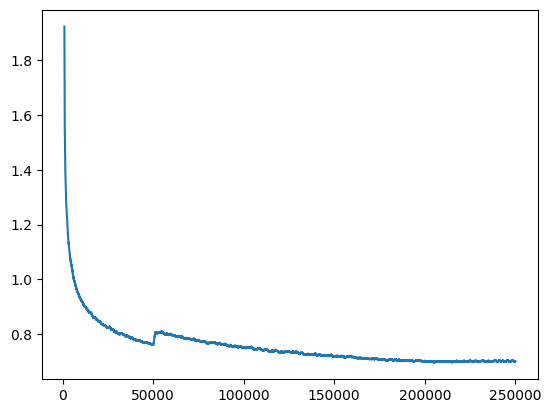

In [18]:
df_loss["loss"].rolling(window=1000).mean().plot()

# Fine tuning para SST-2

## Funciones auxiliares

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Funciones programadas por el prof. Pastor en las prácticas

def get_preds(raw_logits: torch.FloatTensor, return_probs: bool = False) -> np.ndarray:
    probs = nn.functional.softmax(raw_logits.detach(), dim=1)
    if return_probs:
        return probs.cpu().numpy()

    y_pred = torch.argmax(probs, dim=1).cpu().numpy()

    return y_pred


def model_eval(
    data_loader: DataLoader,
    model: nn.Module,
    use_gpu: bool,
    show_report: bool = False,
    label_encoder: Optional[LabelEncoder] = None,
) -> float:
    model.eval()
    preds, tgts = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            y_batch = batch["labels"]

            if use_gpu:
                input_ids = input_ids.to(DEVICE)
                attention_mask = attention_mask.to(DEVICE)

            outputs = model(input_ids, attention_mask)

            # Get prediction
            y_pred = get_preds(outputs)

            if label_encoder is not None:
                y_batch = label_encoder.inverse_transform(y_batch)
                y_pred = label_encoder.inverse_transform(y_pred)

            preds.extend(y_pred)
            tgts.extend(y_batch)

    if show_report:
        # print classification report and confusion matrix as heatmap. label_encoder is necessary
        print(classification_report(tgts, preds))

        plt.figure(figsize=(8, 8))
        sns.heatmap(
            confusion_matrix(tgts, preds),
            annot=True,
            fmt="d",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
        )
        plt.xlabel("Predicción")
        plt.ylabel("Etiqueta")
        plt.title("Matriz de Confusión")
        plt.show()

    return accuracy_score(tgts, preds)


def save_checkpoint_v2(
    state: dict, is_best: bool, checkpoint_path: Path, files_suffix: str
):
    torch.save(state, checkpoint_path / f"checkpoint_{files_suffix}.pt")

    if is_best:
        torch.save(state, checkpoint_path / f"model_best_{files_suffix}.pt")

In [10]:
# Código del prof. Pastor modificado para abstraerlo como función
def train_model(
    model: nn.Module,
    num_epochs: int,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    scheduler: optim.lr_scheduler._LRScheduler,
    train_loader: DataLoader,
    val_loader: DataLoader,
    savedir: Path,
    files_suffix: str,
    label_encoder: Optional[LabelEncoder] = None,
    steps_for_board: int = 50,
) -> tuple[list[float], list[float]]:

    use_gpu = torch.cuda.is_available()
    board_writer = SummaryWriter(tensorboard_dir)

    start_time = time.time()

    best_metric = 0
    n_no_improve = 0
    step = 0

    metric_history = []
    train_metric_history = []

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print(f"Epoch [{epoch + 1}/{num_epochs}]")

        loss_epoch = []
        training_metric = []
        model.train()

        for batch in tqdm(train_loader, desc="Epoch"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            y_batch = batch["labels"].to(DEVICE)

            if use_gpu:
                input_ids = input_ids.to(DEVICE)
                attention_mask = attention_mask.to(DEVICE)
                y_batch = y_batch.to(DEVICE)

            # Forward pass
            logits = model(input_ids, attention_mask)

            loss = criterion(logits, y_batch)

            loss_epoch.append(loss.item())

            # Get training metrics
            y_pred = get_preds(logits)
            tgt = y_batch.cpu().numpy()
            training_metric.append(accuracy_score(tgt, y_pred))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            step +=1

            if step % steps_for_board == 0:
                board_writer.add_scalars(f"Loss {files_suffix}", {"Training": loss.item()}, step)

        # Get metric in validation dataset
        mean_epoch_metric = np.mean(training_metric)
        train_metric_history.append(mean_epoch_metric)

        # Get metric in validation dataset
        tuning_metric = model_eval(val_loader, model, use_gpu)
        metric_history.append(tuning_metric)

        board_writer.add_scalars(f"Accuracy {files_suffix}", {"Training": mean_epoch_metric, "Validation": tuning_metric}, epoch + 1)

        # Update scheduler
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(tuning_metric)
        else:
            scheduler.step()

        # Check for metric improvement
        is_improvement = tuning_metric > best_metric

        if is_improvement:
            best_metric = tuning_metric

        # Save best model if metric improved
        save_checkpoint_v2(
            {
                "epoch": epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "best_metric": best_metric,
            },
            is_improvement,
            savedir,
            files_suffix
        )

        print(f"Loss: {np.mean(loss_epoch):.4f} - Train acc: {mean_epoch_metric:.4f} - Val accuracy: {tuning_metric:.4f} - Epoch time: {time.time() - epoch_start_time:.2f} s""")
        print(f"---{time.time() - start_time:.2f} seconds ---")

    board_writer.flush()
    board_writer.close()

    return metric_history, train_metric_history

## SST-2 dataset (Stanford Sentiment Treebank - v2)

Sentimiento negativo o positivo de reseñas de películas

In [11]:
sst2 = load_dataset("sst2")

README.md:   0%|          | 0.00/5.27k [00:00<?, ?B/s]

In [12]:
sst_label_encoder = LabelEncoder()
sst_label_encoder.fit(["negative", "positive"])

LabelEncoder()

In [13]:
sst2["train"][0]

{'idx': 0,
 'sentence': 'hide new secretions from the parental units ',
 'label': 0}

In [14]:
def tokenize_fn(batch):
    return tokenizer(batch["sentence"], truncation=True)

sst_tkns = sst2.map(
    tokenize_fn,
    batched=True,
    remove_columns=["sentence", "idx"],
)

sst_tkns.set_format("torch")

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [15]:
collator = DataCollatorWithPadding(tokenizer)

BATCH_SIZE = 128

# DataLoaders
sst_train_loader = DataLoader(
    sst_tkns["train"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True,
    collate_fn=collator,
    prefetch_factor=2,
)

sst_val_loader = DataLoader(
    sst_tkns["validation"],
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True,
    collate_fn=collator,
    prefetch_factor=2,
)

## Fine tuning con checkpoints

In [48]:
chkpoints = df_loss[df_loss["step"] % STEPS_FOR_CHKPT == 0]
index = chkpoints["loss"].argmin().item()
step = chkpoints["step"].iloc[index].item()
min_loss = chkpoints["loss"].min()
print(f"Checkpoint {step} con mínimo de función de costo - {min_loss:.6f}")

Checkpoint 236000 con mínimo de función de costo - 0.620741


In [19]:
intermediate_steps = [5000, 20_000, 50_000, 137000, 236000]
df_loss.iloc[[inter_step-1 for inter_step in intermediate_steps]]

,step,loss
4999,5000,1.059250
19999,20000,0.878748
49999,50000,0.774121
136999,137000,0.694326
235999,236000,0.620741


In [20]:
students_chkpt = [
    BertModel(student_config, add_pooling_layer=False).to(DEVICE) for _ in range(len(intermediate_steps))
]

In [21]:
for i, step in enumerate(intermediate_steps):
    students_chkpt[i].load_state_dict(torch.load(savedir / f"chkpnt_step_{step}.pt", map_location=DEVICE)["state_dict"])

In [22]:
class MiniLMClassifier(nn.Module):
    def __init__(self, encoder, num_labels, freeze_backbone: bool = False):
        super().__init__()
        self.encoder = encoder

        if freeze_backbone:
            self.encoder.eval()
            for p in self.encoder.parameters():
                p.requires_grad = False

        self.classifier = nn.Linear(encoder.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids, attention_mask=attention_mask)
        cls_rep = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_rep)
        return logits


In [23]:
classifiers = []
logs = []
for i, step in enumerate(intermediate_steps):
    print("Checkpoint", step, "\n")
    classifier = MiniLMClassifier(students_chkpt[i], num_labels=2, freeze_backbone=False).to(DEVICE)

    # Training hyperparameters
    lr = 5e-4

    # Scheduler hyperparameters
    lr_patience = 5
    lr_factor = 0.5

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        classifier.parameters(),
        lr = lr
        )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer,
                    mode="max", # for monitoring validation accuracy
                    patience = lr_patience,
                    factor = lr_factor
                )

    num_epochs = 10

    files_suffix = f"student_step_{step}"

    metric_history, train_metric_history = train_model(
        classifier,
        num_epochs,
        criterion,
        optimizer,
        scheduler,
        sst_train_loader,
        sst_val_loader,
        savedir_students,
        files_suffix=files_suffix
    )

    logs.append((metric_history, train_metric_history))

    print("\n\n")

    classifiers.append(classifier)

Checkpoint 5000 

Epoch [1/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.3611 - Train acc: 0.8382 - Val accuracy: 0.8073 - Epoch time: 33.33 s
---33.33 seconds ---
Epoch [2/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.1817 - Train acc: 0.9312 - Val accuracy: 0.7959 - Epoch time: 22.56 s
---55.89 seconds ---
Epoch [3/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.1240 - Train acc: 0.9543 - Val accuracy: 0.7924 - Epoch time: 22.59 s
---78.48 seconds ---
Epoch [4/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.1006 - Train acc: 0.9630 - Val accuracy: 0.7924 - Epoch time: 22.55 s
---101.03 seconds ---
Epoch [5/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0871 - Train acc: 0.9662 - Val accuracy: 0.7833 - Epoch time: 22.23 s
---123.26 seconds ---
Epoch [6/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0793 - Train acc: 0.9694 - Val accuracy: 0.7947 - Epoch time: 22.37 s
---145.63 seconds ---
Epoch [7/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0791 - Train acc: 0.9702 - Val accuracy: 0.7856 - Epoch time: 22.34 s
---167.97 seconds ---
Epoch [8/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0526 - Train acc: 0.9800 - Val accuracy: 0.7810 - Epoch time: 22.20 s
---190.17 seconds ---
Epoch [9/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0390 - Train acc: 0.9854 - Val accuracy: 0.7672 - Epoch time: 22.15 s
---212.32 seconds ---
Epoch [10/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0329 - Train acc: 0.9871 - Val accuracy: 0.7787 - Epoch time: 22.34 s
---234.66 seconds ---



Checkpoint 20000 

Epoch [1/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.3553 - Train acc: 0.8418 - Val accuracy: 0.8005 - Epoch time: 31.53 s
---31.53 seconds ---
Epoch [2/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.1748 - Train acc: 0.9336 - Val accuracy: 0.8039 - Epoch time: 23.19 s
---54.72 seconds ---
Epoch [3/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.1185 - Train acc: 0.9564 - Val accuracy: 0.7970 - Epoch time: 23.49 s
---78.21 seconds ---
Epoch [4/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0883 - Train acc: 0.9678 - Val accuracy: 0.7833 - Epoch time: 22.65 s
---100.86 seconds ---
Epoch [5/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0686 - Train acc: 0.9753 - Val accuracy: 0.7901 - Epoch time: 22.87 s
---123.73 seconds ---
Epoch [6/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0616 - Train acc: 0.9772 - Val accuracy: 0.7856 - Epoch time: 22.60 s
---146.34 seconds ---
Epoch [7/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0569 - Train acc: 0.9788 - Val accuracy: 0.7798 - Epoch time: 22.66 s
---169.00 seconds ---
Epoch [8/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0464 - Train acc: 0.9832 - Val accuracy: 0.7729 - Epoch time: 22.60 s
---191.60 seconds ---
Epoch [9/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0274 - Train acc: 0.9905 - Val accuracy: 0.7810 - Epoch time: 22.61 s
---214.20 seconds ---
Epoch [10/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0212 - Train acc: 0.9920 - Val accuracy: 0.7856 - Epoch time: 22.63 s
---236.84 seconds ---



Checkpoint 50000 

Epoch [1/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.3401 - Train acc: 0.8501 - Val accuracy: 0.8360 - Epoch time: 23.08 s
---23.08 seconds ---
Epoch [2/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.1711 - Train acc: 0.9356 - Val accuracy: 0.7959 - Epoch time: 22.71 s
---45.79 seconds ---
Epoch [3/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.1152 - Train acc: 0.9578 - Val accuracy: 0.7913 - Epoch time: 22.60 s
---68.38 seconds ---
Epoch [4/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0880 - Train acc: 0.9681 - Val accuracy: 0.7798 - Epoch time: 22.52 s
---90.90 seconds ---
Epoch [5/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0749 - Train acc: 0.9727 - Val accuracy: 0.7764 - Epoch time: 22.55 s
---113.45 seconds ---
Epoch [6/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0617 - Train acc: 0.9781 - Val accuracy: 0.7856 - Epoch time: 22.59 s
---136.04 seconds ---
Epoch [7/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0540 - Train acc: 0.9808 - Val accuracy: 0.7821 - Epoch time: 22.48 s
---158.52 seconds ---
Epoch [8/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0319 - Train acc: 0.9889 - Val accuracy: 0.7810 - Epoch time: 22.61 s
---181.13 seconds ---
Epoch [9/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0224 - Train acc: 0.9918 - Val accuracy: 0.7844 - Epoch time: 22.54 s
---203.68 seconds ---
Epoch [10/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0196 - Train acc: 0.9926 - Val accuracy: 0.7947 - Epoch time: 22.59 s
---226.27 seconds ---



Checkpoint 137000 

Epoch [1/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.3358 - Train acc: 0.8529 - Val accuracy: 0.8291 - Epoch time: 23.10 s
---23.10 seconds ---
Epoch [2/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.1643 - Train acc: 0.9387 - Val accuracy: 0.8314 - Epoch time: 23.21 s
---46.31 seconds ---
Epoch [3/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.1098 - Train acc: 0.9596 - Val accuracy: 0.8188 - Epoch time: 24.58 s
---70.89 seconds ---
Epoch [4/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0770 - Train acc: 0.9720 - Val accuracy: 0.8108 - Epoch time: 22.62 s
---93.52 seconds ---
Epoch [5/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0624 - Train acc: 0.9776 - Val accuracy: 0.8131 - Epoch time: 22.66 s
---116.18 seconds ---
Epoch [6/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0507 - Train acc: 0.9818 - Val accuracy: 0.7947 - Epoch time: 22.49 s
---138.67 seconds ---
Epoch [7/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0412 - Train acc: 0.9847 - Val accuracy: 0.8073 - Epoch time: 22.48 s
---161.15 seconds ---
Epoch [8/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0377 - Train acc: 0.9864 - Val accuracy: 0.7982 - Epoch time: 22.58 s
---183.74 seconds ---
Epoch [9/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0218 - Train acc: 0.9920 - Val accuracy: 0.8073 - Epoch time: 22.66 s
---206.40 seconds ---
Epoch [10/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0134 - Train acc: 0.9948 - Val accuracy: 0.8005 - Epoch time: 22.90 s
---229.29 seconds ---



Checkpoint 236000 

Epoch [1/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.3325 - Train acc: 0.8525 - Val accuracy: 0.8337 - Epoch time: 23.05 s
---23.05 seconds ---
Epoch [2/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.1590 - Train acc: 0.9407 - Val accuracy: 0.8394 - Epoch time: 24.09 s
---47.14 seconds ---
Epoch [3/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.1052 - Train acc: 0.9615 - Val accuracy: 0.8291 - Epoch time: 27.05 s
---74.19 seconds ---
Epoch [4/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0752 - Train acc: 0.9731 - Val accuracy: 0.8349 - Epoch time: 22.20 s
---96.39 seconds ---
Epoch [5/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0590 - Train acc: 0.9790 - Val accuracy: 0.8028 - Epoch time: 22.29 s
---118.68 seconds ---
Epoch [6/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0481 - Train acc: 0.9828 - Val accuracy: 0.8096 - Epoch time: 22.28 s
---140.97 seconds ---
Epoch [7/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0431 - Train acc: 0.9847 - Val accuracy: 0.8131 - Epoch time: 22.24 s
---163.21 seconds ---
Epoch [8/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0358 - Train acc: 0.9873 - Val accuracy: 0.8119 - Epoch time: 22.22 s
---185.42 seconds ---
Epoch [9/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0224 - Train acc: 0.9919 - Val accuracy: 0.8096 - Epoch time: 22.12 s
---207.55 seconds ---
Epoch [10/10]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0142 - Train acc: 0.9948 - Val accuracy: 0.8085 - Epoch time: 22.21 s
---229.75 seconds ---





## Entrenamiento desde cero

In [35]:
student_scratch = BertModel(student_config, add_pooling_layer=False)
classifier_scratch = MiniLMClassifier(student_scratch, num_labels=2, freeze_backbone=False).to(DEVICE)

# Training hyperparameters
lr = 1e-3

# Scheduler hyperparameters
lr_patience = 5
lr_factor = 0.5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    classifier_scratch.parameters(),
    lr = lr
    )

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="max", # for monitoring validation accuracy
                patience = lr_patience,
                factor = lr_factor
            )

num_epochs = 10

files_suffix = f"student_scratch"

metric_history, train_metric_history = train_model(
    classifier_scratch,
    num_epochs,
    criterion,
    optimizer,
    scheduler,
    sst_train_loader,
    sst_val_loader,
    savedir_students,
    files_suffix=files_suffix
)

Epoch [1/15]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.4667 - Train acc: 0.7841 - Val accuracy: 0.7798 - Epoch time: 23.86 s
---23.86 seconds ---
Epoch [2/15]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.2783 - Train acc: 0.8920 - Val accuracy: 0.7695 - Epoch time: 22.61 s
---46.47 seconds ---
Epoch [3/15]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.2362 - Train acc: 0.9112 - Val accuracy: 0.7718 - Epoch time: 22.35 s
---68.82 seconds ---
Epoch [4/15]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.2536 - Train acc: 0.9038 - Val accuracy: 0.7489 - Epoch time: 22.79 s
---91.61 seconds ---
Epoch [5/15]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.2950 - Train acc: 0.8822 - Val accuracy: 0.7317 - Epoch time: 22.90 s
---114.51 seconds ---
Epoch [6/15]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.2400 - Train acc: 0.9072 - Val accuracy: 0.7706 - Epoch time: 22.91 s
---137.42 seconds ---
Epoch [7/15]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.2142 - Train acc: 0.9208 - Val accuracy: 0.7443 - Epoch time: 22.83 s
---160.25 seconds ---
Epoch [8/15]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.1938 - Train acc: 0.9288 - Val accuracy: 0.7328 - Epoch time: 22.82 s
---183.07 seconds ---
Epoch [9/15]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.1807 - Train acc: 0.9348 - Val accuracy: 0.7477 - Epoch time: 23.35 s
---206.42 seconds ---
Epoch [10/15]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.1746 - Train acc: 0.9370 - Val accuracy: 0.7511 - Epoch time: 22.93 s
---229.35 seconds ---
Epoch [11/15]


Epoch:   0%|          | 0/527 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Comparación

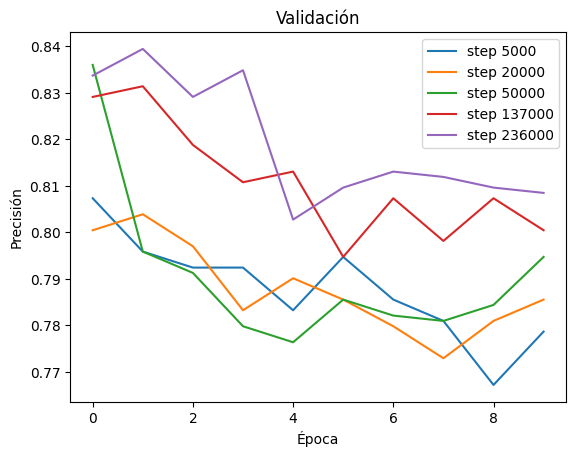

In [28]:
for log, label in zip(logs, intermediate_steps):
    plt.plot(log[0], label=f"step {label}")
    plt.xlabel("Época")
    plt.ylabel("Precisión")
    plt.legend()

plt.title("Validación")
plt.show()

In [29]:
use_gpu = torch.cuda.is_available()

Checkpoint 5000 



Validation:   0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.85      0.74      0.79       428
    positive       0.77      0.88      0.82       444

    accuracy                           0.81       872
   macro avg       0.81      0.81      0.81       872
weighted avg       0.81      0.81      0.81       872



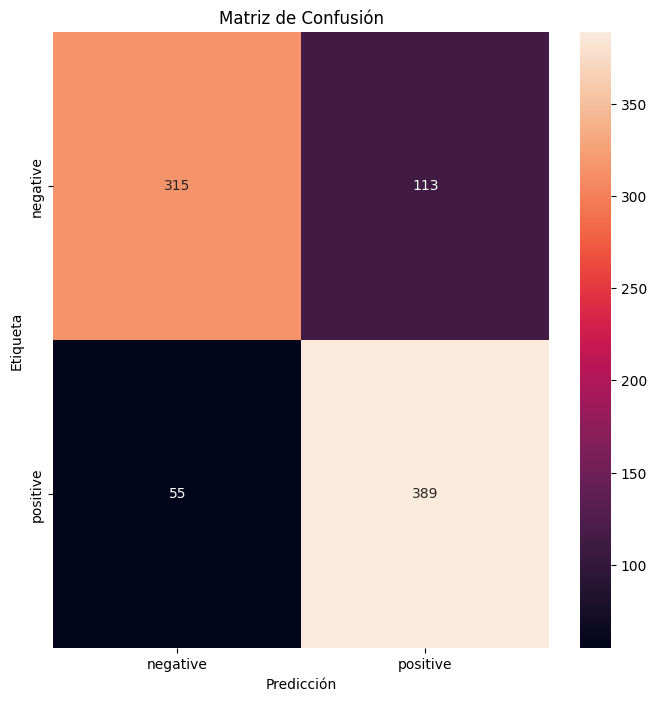




Checkpoint 20000 



Validation:   0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.77      0.85      0.81       428
    positive       0.84      0.76      0.80       444

    accuracy                           0.80       872
   macro avg       0.81      0.80      0.80       872
weighted avg       0.81      0.80      0.80       872



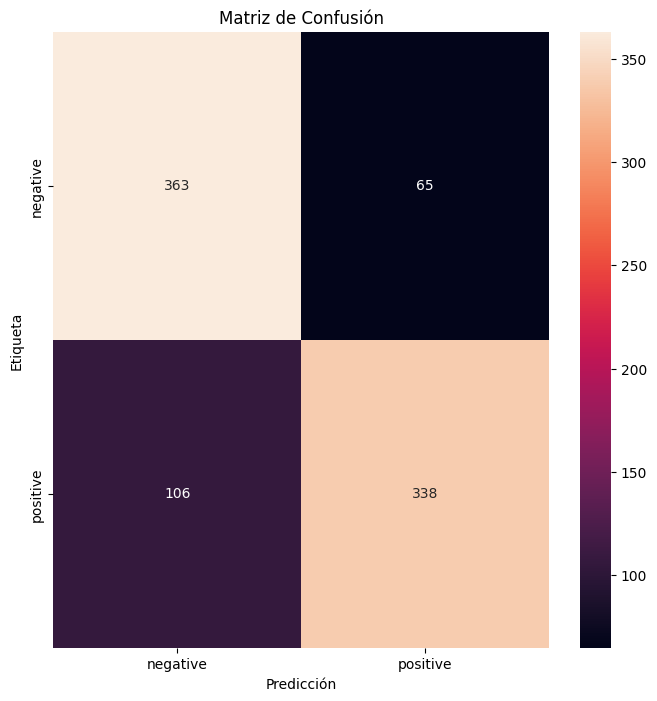




Checkpoint 50000 



Validation:   0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.83      0.83      0.83       428
    positive       0.84      0.84      0.84       444

    accuracy                           0.84       872
   macro avg       0.84      0.84      0.84       872
weighted avg       0.84      0.84      0.84       872



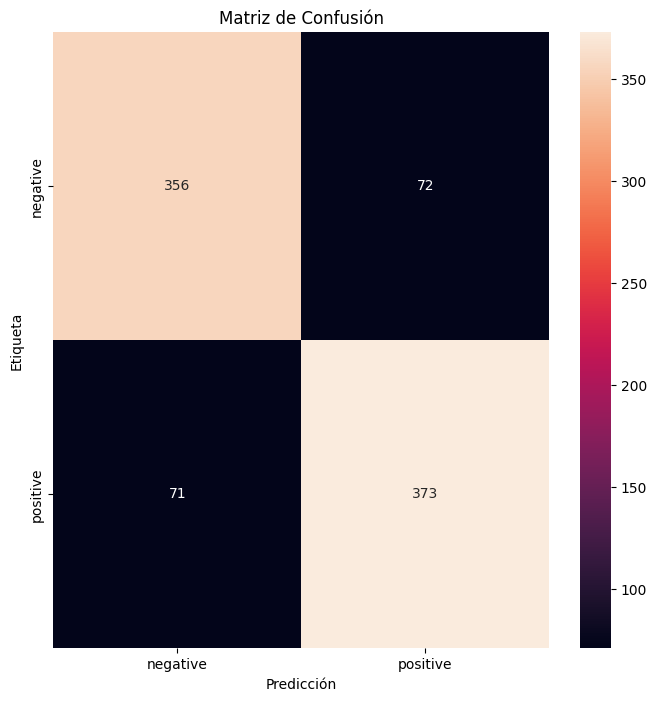




Checkpoint 137000 



Validation:   0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.85      0.80      0.82       428
    positive       0.82      0.86      0.84       444

    accuracy                           0.83       872
   macro avg       0.83      0.83      0.83       872
weighted avg       0.83      0.83      0.83       872



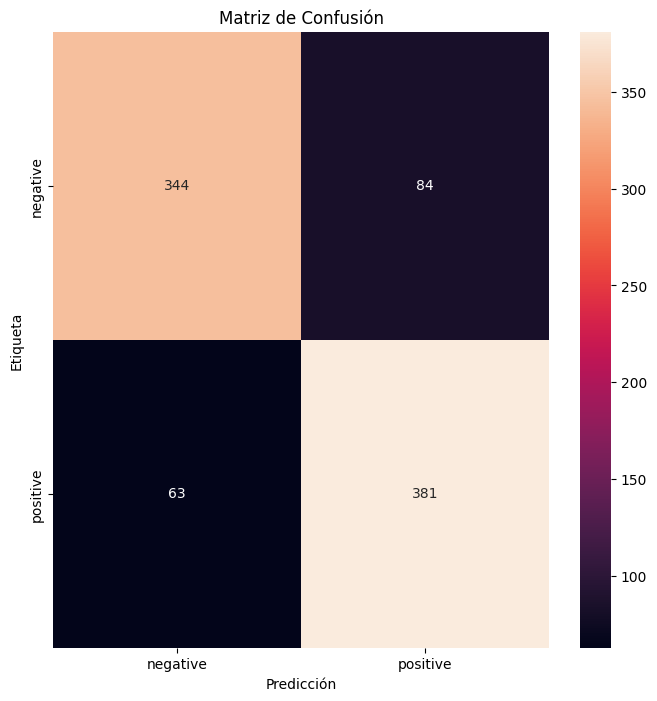




Checkpoint 236000 



Validation:   0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.83      0.84      0.84       428
    positive       0.85      0.84      0.84       444

    accuracy                           0.84       872
   macro avg       0.84      0.84      0.84       872
weighted avg       0.84      0.84      0.84       872



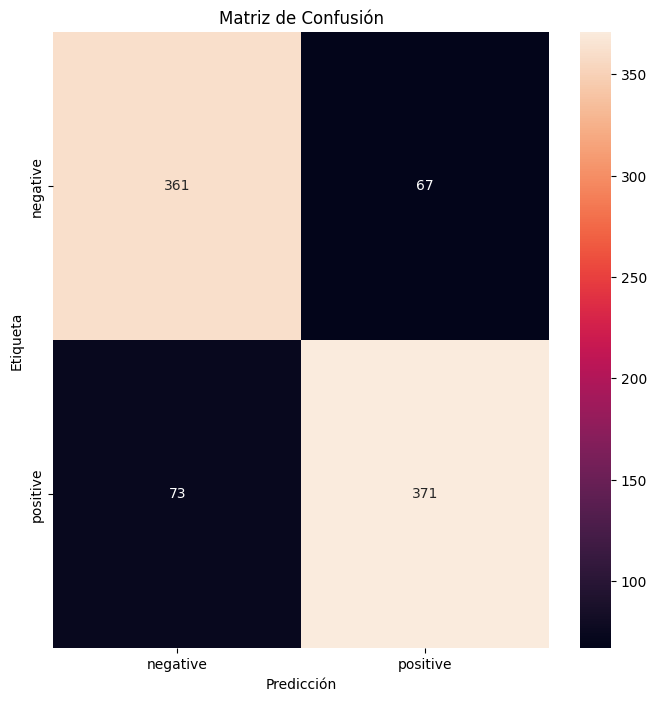

In [30]:
best_classifiers = []
acc_per_model = []

for i in range(len(intermediate_steps)):
    print("Checkpoint", intermediate_steps[i], "\n")
    classifier = MiniLMClassifier(students_chkpt[i], num_labels=2, freeze_backbone=False).to(DEVICE)
    classifier.load_state_dict(
        torch.load(savedir_students / f"model_best_student_step_{intermediate_steps[i]}.pt", map_location=DEVICE)["state_dict"]
        )
    best_classifiers.append(classifier)


    acc = model_eval(sst_val_loader, classifier, use_gpu, show_report=True, label_encoder=sst_label_encoder)

    acc_per_model.append(acc)

    print("\n\n")

In [31]:
student_scratch = BertModel(student_config, add_pooling_layer=False)
best_scratch = MiniLMClassifier(student_scratch, num_labels=2, freeze_backbone=False).to(DEVICE)
best_scratch.load_state_dict(
    torch.load(savedir_students / f"model_best_student_scratch.pt", map_location=DEVICE)["state_dict"]
)

<All keys matched successfully>

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.78      0.76      0.77       428
    positive       0.78      0.80      0.79       444

    accuracy                           0.78       872
   macro avg       0.78      0.78      0.78       872
weighted avg       0.78      0.78      0.78       872



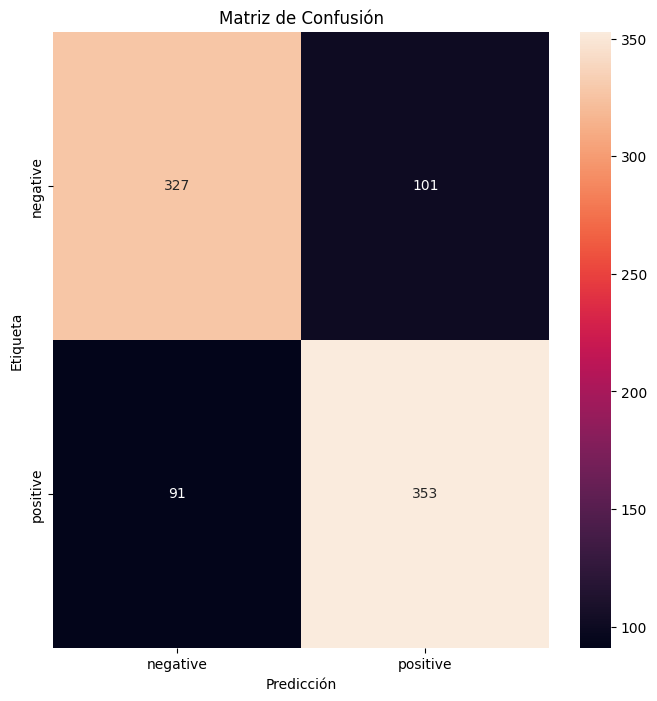

In [32]:
scratch_acc = model_eval(sst_val_loader, best_scratch, use_gpu, show_report=True, label_encoder=sst_label_encoder)

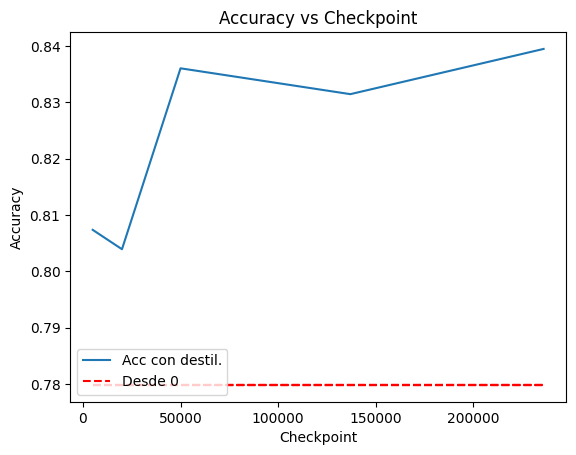

In [36]:
plt.plot(intermediate_steps, acc_per_model, label="Acc con destil.")
plt.xlabel("Checkpoint")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Checkpoint")
plt.hlines([scratch_acc]*len(intermediate_steps), min(intermediate_steps), max(intermediate_steps), linestyles="dashed", color="red", label="Desde 0")
plt.legend()
plt.show()